## Дз 8: "Metric learning"

## Цель задания:
Познакомится с алгоритмами metric learning
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу поиска похожего автомобиля в базе данных (автомобиля того же класса). На основе датасета [cars196](https://paperswithcode.com/sota/metric-learning-on-cars196) , ссылка на данные [мета](https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing) [data](https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing).

Процесс выполнения задания следующий:

0. Выбор модели эмбеддера:
    1. Выберите модель кодирующую изображения для выполнения домашнего задания. Любую, кроме модели resnet50.

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера).
    2. Добавьте аугментации в датасет **0.5 балла**.

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте train-loop для вашей модели и проведите обучение c Triplet loss **2 балла**.
    2. При формировании триплета не просто брать отрицательный класс, а воспользоваться техникой hard negative mining **0.5 балла**.
    3. Обучите модель и воcпользуйте иными loss функциями для задачи metric learning **0.5 балла**.
    4. Полезные ссылки [тык](https://github.com/KevinMusgrave/pytorch-metric-learning)
 
3. Валидация обученных моделей на тестовой выборке, вычисление метрики Recall и Precision
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрики поиска Recall@1, Recall@5, Precision@1, Precision@5. Обратите внимание, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта, а должны производить поиск на основе получившихся эмбеддингов (пример в [семинаре](metric_learning.ipynb) блок Faiss). **0.5 балла**
    2. При поиске воспользоваться библиотекой Faiss **0.5 балла**

4. Выводы:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.
    3. Проинтерпретируйте результаты работы модели с помощью [GradCam](https://github.com/jacobgil/pytorch-grad-cam)  **0.5 балла**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 18 марта.


In [5]:
import gdown

In [6]:
!mkdir cars

mkdir: cannot create directory ‘cars’: File exists


In [7]:
output = "/kaggle/working/cars/dataset.zip"
file_id = "1l9EnYMC-xGX706SY1kN8RceMmFViASfx"
print('https://drive.google.com/uc?export=download&id=' + file_id)
gdown.download('https://drive.google.com/uc?export=download&id='+ file_id, output, quiet=False)

https://drive.google.com/uc?export=download&id=1l9EnYMC-xGX706SY1kN8RceMmFViASfx


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1l9EnYMC-xGX706SY1kN8RceMmFViASfx
From (redirected): https://drive.google.com/uc?export=download&id=1l9EnYMC-xGX706SY1kN8RceMmFViASfx&confirm=t&uuid=c0d36576-16d8-440d-9943-a218edb5fbe5
To: /kaggle/working/cars/dataset.zip
100%|██████████| 1.96G/1.96G [00:08<00:00, 244MB/s] 


'/kaggle/working/cars/dataset.zip'

In [8]:
!unzip "/kaggle/working/cars/dataset.zip"

Archive:  /kaggle/working/cars/dataset.zip
replace cars_annos.mat? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [21]:
import cv2
import os
import matplotlib.pyplot as plt
import random
import pandas as pd
device = 'cuda'

In [22]:
import scipy.io
mat = scipy.io.loadmat('/kaggle/input/devkit-cars/devkit/cars_train_annos.mat')
fname_to_class = {fname:cl-1 for fname, cl in zip([i[0] for i in mat['annotations'][0]['fname']], 
                                                [i[0][0] for i in mat['annotations'][0]['class']])}
cars_meta = scipy.io.loadmat('/kaggle/input/devkit-cars/devkit/cars_meta.mat')
id_to_car = {idx: car[0] for idx, car in enumerate(cars_meta['class_names'][0])}

In [23]:
ADD_PATH = '/kaggle/working/cars_train/cars_train'

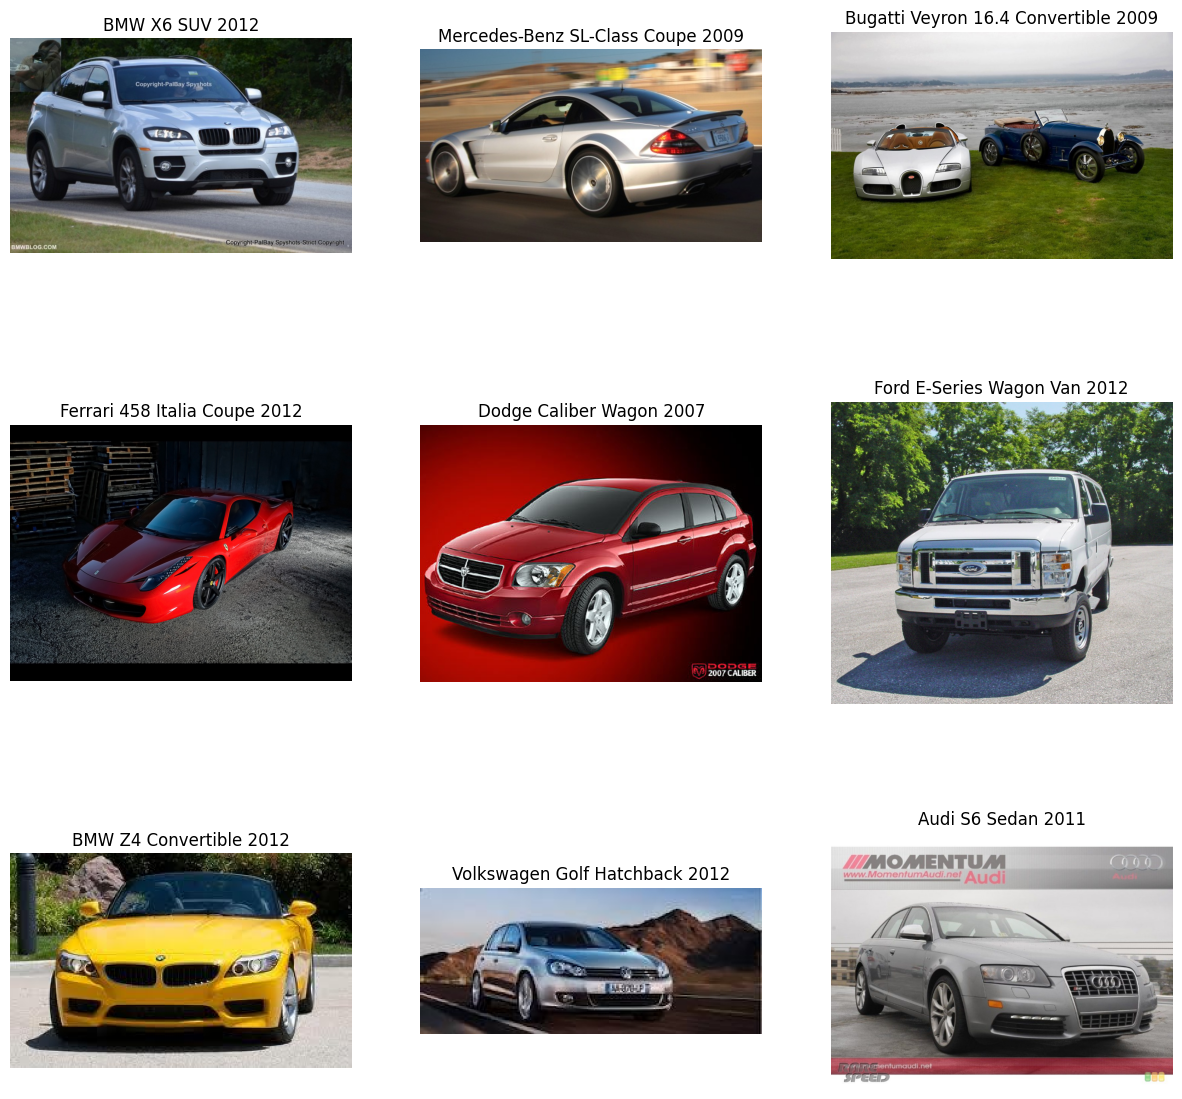

In [24]:
num_imgs = 9
cols = 3
rows = num_imgs // cols
fig, ax = plt.subplots(rows, cols, figsize = (15, 15))
for idx, im_idx in enumerate(random.sample([i for i in range(len(fname_to_class))], num_imgs)):
    filename, cl_id = list(fname_to_class.items())[im_idx]
    temp_image = cv2.imread(os.path.join(ADD_PATH, filename))
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
    ax[idx//cols][idx%cols].imshow(temp_image)
    ax[idx//cols][idx%cols].set_title(f'{id_to_car[cl_id]}')
    ax[idx//cols][idx%cols].axis('off')

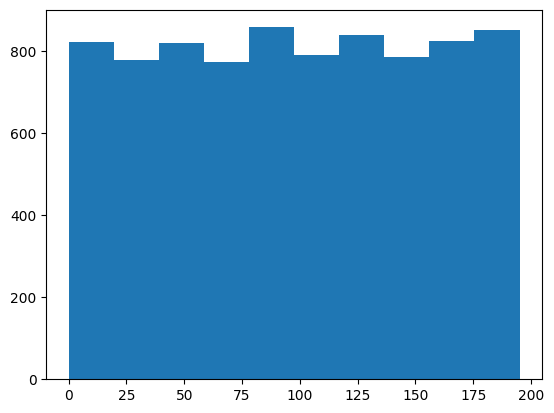

In [25]:
plt.hist(fname_to_class.values())
plt.show()

In [26]:
import torch
import torchvision
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms =  torchvision.transforms.Compose([
            torchvision.transforms.Resize(
                size=(224, 224)
            ),
            torchvision.transforms.ToTensor(),  
            torchvision.transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
            ])

class CropClassifDataset(torch.utils.data.Dataset):
    def __init__(self, cars_items, transforms):
        self.cars = cars_items
        self.transforms = transforms
        
    def __len__(self):
        return len(self.cars)

    def __getitem__(self, idx):
        filename, cl_id = self.cars[idx]
        image = cv2.imread(os.path.join(ADD_PATH, filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        
        if self.transforms:
            image = self.transforms(image)
        return image, cl_id

items = list(fname_to_class.items())
random.shuffle(items)
train_items = items[:int(len(items) * 0.8)]
val_items = items[int(len(items) * 0.8):]

train_dataset = CropClassifDataset(train_items, train_transforms)
val_dataset = CropClassifDataset(val_items, val_transforms)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, collate_fn=None, pin_memory=True, drop_last = True)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4, collate_fn=None, pin_memory=True)

In [27]:
batch = next(iter(train_loader))

images, labels = batch

print("Размерность изображений:", images.shape)
print("Размерность меток:", labels.shape)

Размерность изображений: torch.Size([64, 3, 224, 224])
Размерность меток: torch.Size([64])


In [28]:
import torch.nn as nn
import torchvision.models as models

class CarEmbeddingModel(nn.Module):
    def __init__(self, embed_size=128):
        super(CarEmbeddingModel, self).__init__()
        self.backbone = models.efficientnet_b3(weights='IMAGENET1K_V1')
        self.backbone.classifier = nn.Identity()
        self.embedding = nn.Linear(1536, embed_size)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        return x

# Hard negative mining

In [1]:
def hard_negative_mining(anchor, positive, negatives):
    """
    Выбирает "hard negative" среди всех отрицательных примеров.
    """
    distances = torch.norm(anchor.unsqueeze(0) - negatives, dim=1)
    hardest_negative_idx = torch.argmin(distances)
    return negatives[hardest_negative_idx]

# Train loop with Triplet Loss

In [29]:
import numpy as np

In [69]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CarEmbeddingModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.TripletMarginLoss(margin=1.0)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        embeddings = model(images)

        anchor, positive, negative = [], [], []
        for i in range(len(labels)):
            pos_idx = (labels == labels[i]).nonzero(as_tuple=True)[0]
            neg_idx = (labels != labels[i]).nonzero(as_tuple=True)[0]

            if len(pos_idx) > 1 and len(neg_idx) > 0:
                pos = embeddings[pos_idx[0]]
                neg = hard_negative_mining(embeddings[i], pos, embeddings[neg_idx])
                anchor.append(embeddings[i])
                positive.append(pos)
                negative.append(neg)

        if len(anchor) > 0:
            anchor = torch.stack(anchor)
            positive = torch.stack(positive)
            negative = torch.stack(negative)

            loss = criterion(anchor, positive, negative)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


Epoch [1/10], Loss: 69.9333
Epoch [2/10], Loss: 64.9679
Epoch [3/10], Loss: 62.7683
Epoch [4/10], Loss: 62.6946
Epoch [5/10], Loss: 62.2258
Epoch [6/10], Loss: 62.0340
Epoch [7/10], Loss: 61.9317
Epoch [8/10], Loss: 61.2656
Epoch [9/10], Loss: 61.4625
Epoch [10/10], Loss: 61.4370


In [74]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    embeddings = []
    labels = []

    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.to(device)
            output = model(images)
            embeddings.append(output.cpu().numpy())
            labels.append(lbls.numpy())

    embeddings = np.vstack(embeddings)
    labels = np.hstack(labels)
    return embeddings, labels

In [ ]:
test_embeddings, test_labels = extract_embeddings(model, valid_loader, device)

In [76]:
!pip install faiss-gpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 20.1 MB/s eta 0:00:00:00:0100:01


# Calculate metrics with FAISS

In [77]:
import faiss

In [78]:
embedding_dim = test_embeddings.shape[1]

index = faiss.IndexFlatL2(embedding_dim)
index.add(test_embeddings)

k = 5
distances, neighbors = index.search(test_embeddings, k)

In [80]:
 neighbors

array([[   0, 1626,  332, 1472, 1457],
       [   1,  677, 1585,   98, 1371],
       [   2,  102,  471,  323, 1277],
       ...,
       [1626,  344,    0,  471,  270],
       [1627,  521, 1585,   10,   37],
       [1628, 1252,    0,  653,  137]])

In [81]:
def compute_metrics(neighbors, test_labels, k):
    recall_at_k = 0
    precision_at_k = 0

    for i in range(len(test_labels)):
        true_label = test_labels[i]
        retrieved_labels = test_labels[neighbors[i][:k]]

        recall_at_k += int(true_label in retrieved_labels)

        precision_at_k += np.sum(retrieved_labels == true_label) / k

    recall_at_k /= len(test_labels)
    precision_at_k /= len(test_labels)

    return recall_at_k, precision_at_k


recall_1, precision_1 = compute_metrics(neighbors, test_labels, 1)
recall_5, precision_5 = compute_metrics(neighbors, test_labels, 5)

print(f"Recall@1: {recall_1:.4f}, Precision@1: {precision_1:.4f}")
print(f"Recall@5: {recall_5:.4f}, Precision@5: {precision_5:.4f}")

Recall@1: 0.9994, Precision@1: 0.9994
Recall@5: 1.0000, Precision@5: 0.2454


In [83]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.0 MB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39648 sha256=34cd3b9682772feedd869b819048f2c0612592ad3e32e45c97babb0ca634d0c6
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


пока не получилось

# Train Loop with ArcFace Loss

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ArcFaceLoss(nn.Module):
    def __init__(self, num_classes, embedding_size=128, scale=30.0, margin=0.5):
        super(ArcFaceLoss, self).__init__()
        self.scale = scale
        self.margin = margin
        self.num_classes = num_classes
        
        self.weights = nn.Parameter(torch.randn(num_classes, embedding_size))
        nn.init.xavier_uniform_(self.weights)

    def forward(self, embeddings, labels):
        normalized_weights = F.normalize(self.weights, p=2, dim=1)  
        normalized_embeddings = F.normalize(embeddings, p=2, dim=1)

        cosine_sim = torch.matmul(normalized_embeddings, normalized_weights.T)  

        one_hot = torch.zeros_like(cosine_sim)
        one_hot.scatter_(1, labels.view(-1, 1), 1.0)  

        cos_theta_m = cosine_sim - self.margin * one_hot  
        logits = self.scale * cos_theta_m

        loss = F.cross_entropy(logits, labels)
        return loss

In [31]:
torch.cuda.empty_cache()

In [32]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 196
model = CarEmbeddingModel().to(device)
arcface_loss = ArcFaceLoss(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
torch.cuda.empty_cache()

print(device)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in train_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)

        embeddings = model(images)
        loss = arcface_loss(embeddings, labels)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")


cuda
Epoch [1/10], Loss: 2175.2897
Epoch [2/10], Loss: 2053.7857
Epoch [3/10], Loss: 1993.2369
Epoch [4/10], Loss: 1920.0385
Epoch [5/10], Loss: 1829.2442
Epoch [6/10], Loss: 1730.9178
Epoch [7/10], Loss: 1632.3793
Epoch [8/10], Loss: 1526.2225
Epoch [9/10], Loss: 1434.7195
Epoch [10/10], Loss: 1341.7301
